# Tutorial 2: Visualize BYOL-A features of audios with pitch and amplitude changes

This tutorial visualizes BYOL-A features for variations of an audio sample.

You can find how the resulting feature representations change.


### ⚠ Setup before you proceed ⚠

If you have not setup, run the commands in [Setup-commands.txt](../Setup-commands.txt).

---
### 0.1 Making the notebook work better

First, setup autoloading of this notebook. Thanks to https://github.com/ipython/ipython/issues/9732

In [1]:
import IPython

from IPython import get_ipython
ipython = get_ipython()
ipython.magic('reload_ext autoreload')
ipython.magic('autoreload 2')
ipython.magic('matplotlib inline')

### 0.2 Adding path and import modules

We append root folder and EVAR folder to the system `path`.

In [2]:
import sys
sys.path.extend(['..', '../evar'])

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torchaudio

from IPython.display import display, Audio

---
## 1. Load and convert an audio clip to a spectrogram

We use a dog voice (Toro, a Shiba-Inu).

<img src="shibainu-toro.jpg" width="250" />

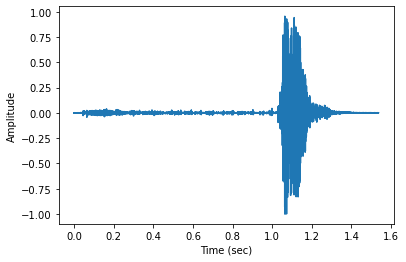

In [4]:
wav, sr = torchaudio.load('barking-shibainu.wav')
wav = wav.mean(0)
plt.plot(np.linspace(0.0, len(wav)/sr, len(wav)), wav)
plt.xlabel('Time (sec)'); plt.ylabel('Amplitude');

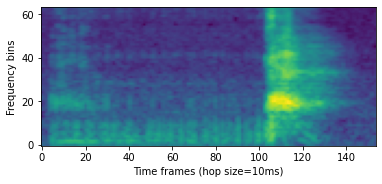

In [9]:
def to_lms(wav, sr):
    return torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=2048, f_max=7800, f_min=60, n_mels=64,
                hop_length=sr//100)(wav).log()

X = to_lms(wav, sr)
_mu, _sigma = X.mean(), X.std()  # calculate stats
X = (X - _mu) / max(_sigma, 1e-12) # normalize
plt.imshow(X, origin='lower')
plt.xlabel('Time frames (hop size=10ms)'); plt.ylabel('Frequency bins');

#### Load the BYOL-A model

In [11]:
from external.byol_a.byol_a.models import AudioNTT2020Task6

# instantiate model.
model = AudioNTT2020Task6(n_mels=64, d=2048)
# evaluation mode.
model.eval()
# load weights.
model.load_state_dict(torch.load('../evar/external/byol_a/pretrained_weights/AudioNTT2020-BYOLA-64x96d2048.pth'))

<All keys matched successfully>

## Make changes to the pitch

We simply time stretch the sample, then the pitch changes.

In [8]:
# higher pitch = shortened sample
wav080 = torch.nn.functional.interpolate(wav.view(1, 1, -1), scale_factor=0.8).view(-1)

# lower pitch = stretched 
wav120 = torch.nn.functional.interpolate(wav.view(1, 1, -1), scale_factor=1.2).view(-1)

print('normal')
display(Audio(wav, rate=sr)); plt.show()
print('higher pitch')
display(Audio(wav080, rate=sr)); plt.show()
print('lower pitch')
display(Audio(wav120, rate=sr)); plt.show()

normal


higher pitch


lower pitch


normal


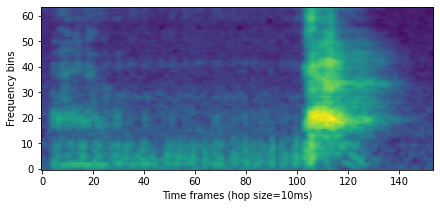

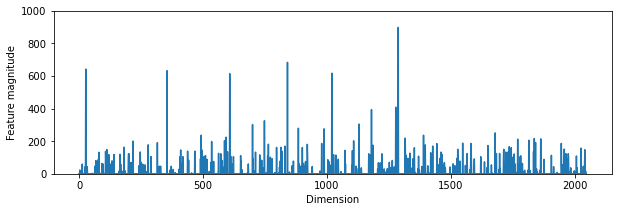

higher pitch


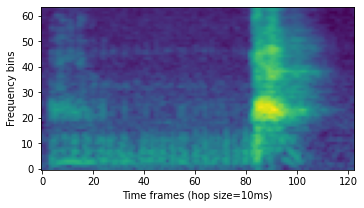

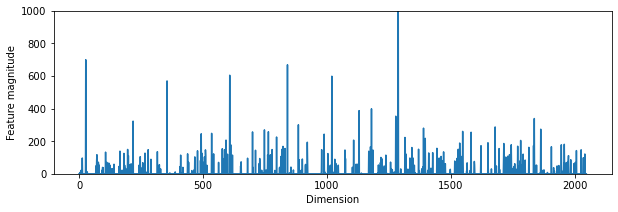

lower pitch


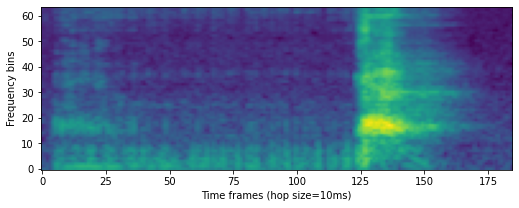

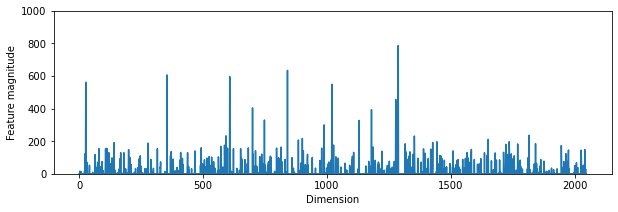

In [16]:
def lms_and_feature(model, wav, sr, at=0.7, figsize=(10, 3), ylim=[0, 1000], normal_wav=None):
    nX = to_lms(normal_wav, sr)
    _mu, _sigma = nX.mean(), nX.std()  # calculate stats

    X = to_lms(wav, sr)
    X = (X - _mu) / max(_sigma, 1e-12) # normalize
    plt.figure(figsize=figsize); plt.imshow(X, origin='lower')
    plt.xlabel('Time frames (hop size=10ms)'); plt.ylabel('Frequency bins'); plt.show()
    
    y = model(X.view(1, 1, X.shape[0], X.shape[1])).detach().numpy()
    j_at = int(y.shape[1] * at)
    plt.figure(figsize=figsize); plt.plot(y[0, j_at]); plt.ylim(ylim)
    plt.ylabel('Feature magnitude'); plt.xlabel('Dimension'); plt.show()

print('normal')
lms_and_feature(model, wav, sr, normal_wav=wav)
print('higher pitch')
lms_and_feature(model, wav080, sr, normal_wav=wav)
print('lower pitch')
lms_and_feature(model, wav120, sr, normal_wav=wav)

## Make changes to the amplitude

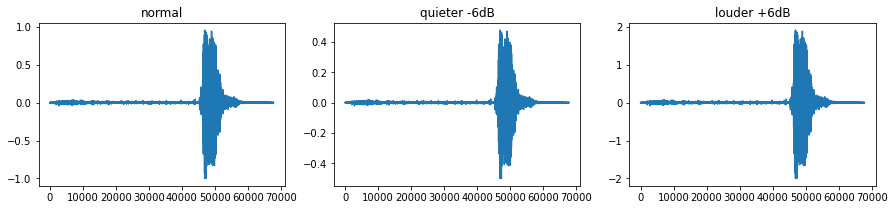

In [24]:
wav_quiet = wav * 0.5
wav_loud = wav * 2

plt.figure(figsize=(15, 3))
plt.subplot(131); plt.title('normal')
plt.plot(wav)
plt.subplot(132); plt.title('quieter -6dB')
plt.plot(wav_quiet)
plt.subplot(133); plt.title('louder +6dB')
plt.plot(wav_loud)

normal


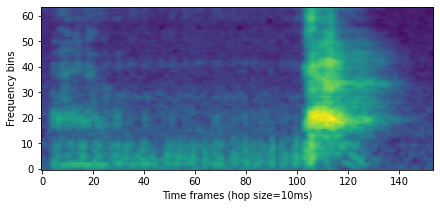

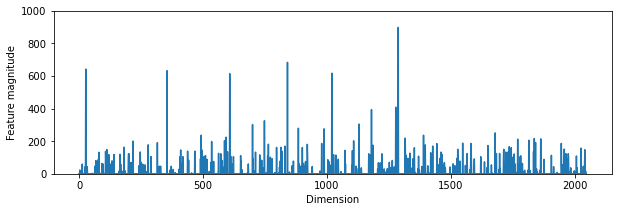

quieter -6dB


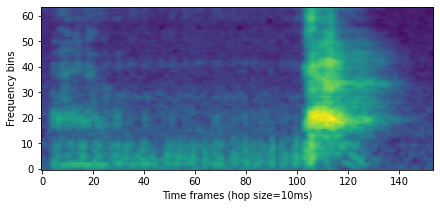

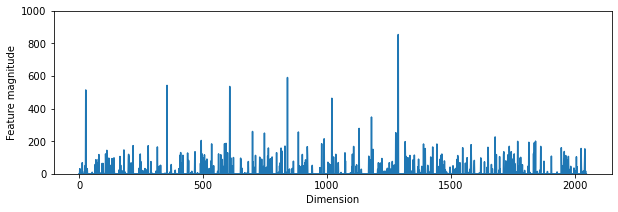

louder +6dB


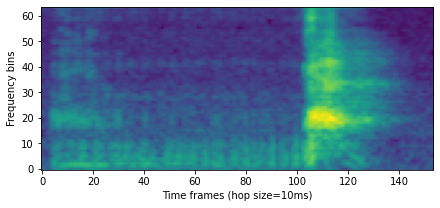

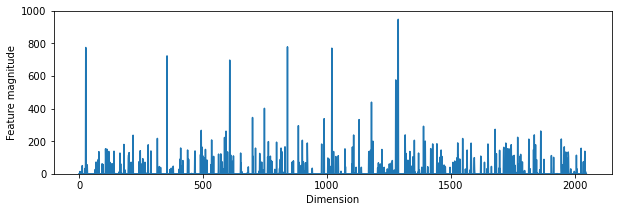

In [19]:
print('normal')
lms_and_feature(model, wav, sr, normal_wav=wav)
print('quieter -6dB')
lms_and_feature(model, wav_quiet, sr, normal_wav=wav)
print('louder +6dB')
lms_and_feature(model, wav_loud, sr, normal_wav=wav)